# Matplotlib to TypeScript Colormap Generator

This notebook extracts colormaps from matplotlib and generates TypeScript files for each colormap.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pathlib import Path
import matplotlib.colors as mcolors
import matplotlib.cm as mcm
from IPython.display import display, Image
import cmocean
import cmasher
import colorcet
# Create output directory
output_dir = Path("src/colormaps")
output_dir.mkdir(exist_ok=True)

# Get all available colormaps
colormap_names = plt.colormaps()

def get_colormaps_lists(cmap_name, num_points=256):
    """Extract RGB values from matplotlib colormap"""
    cmap = cm.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, num_points))
    
    # Extract RGB channels (ignore alpha)
    r_values = colors[:, 0].tolist()
    g_values = colors[:, 1].tolist()
    b_values = colors[:, 2].tolist()
    
    return r_values, g_values, b_values

print(f"Found {len(colormap_names)} colormaps")


Found 824 colormaps


In [2]:
def snake_to_camel(snake_str):
    """Convert snake_case to camelCase"""
    components = snake_str.split('_')
    return components[0] + ''.join(x.title() for x in components[1:])

In [3]:
def sanitize_cmap_name(cmap_name):
    """Sanitize colormap name to be a valid TypeScript identifier"""
    sanitized = cmap_name.replace('-', '_').replace(' ', '_').replace('.', '_')
    if sanitized[0].isdigit():
        sanitized = '_' + sanitized
    return sanitized

def generate_typescript_file(cmap_name, r_values, g_values, b_values):
    sanitized_cmap_name = sanitize_cmap_name(cmap_name)
    """Generate TypeScript file for a single colormap"""
    ts_content = f'''
import type {{ ColorMap }} from "../types.js";

export const {sanitized_cmap_name}: ColorMap = {{
  r: {list(r_values)},
  g: {list(g_values)},
  b: {list(b_values)},
}};
'''

    
    file_path = output_dir / f"{sanitized_cmap_name}.ts"
    with open(file_path, 'w') as f:
        f.write(ts_content)
    
    return file_path

# Generate files for each colormap
generated_files = []
for cmap_name in colormap_names:  # Start with first 5 for testing
    try:
        r_vals, g_vals, b_vals = get_colormaps_lists(cmap_name)
        file_path = generate_typescript_file(cmap_name, r_vals, g_vals, b_vals)
        generated_files.append((cmap_name, file_path))
        # print(f"Generated: {file_path}")
    except Exception as e:
        print(f"Error generating {cmap_name}: {e}")

print(f"\nGenerated {len(generated_files)} colormap files")

/var/folders/yl/7lc06h196yd8dcv50gljyg7h0000gq/T/ipykernel_33335/3440709671.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)



Generated 824 colormap files


In [4]:
# Generated by Copilot
def generate_index_file(colormap_names):
    """Generate index file that exports all colormaps"""
    imports = []
    exports = []
    
    for cmap_name in colormap_names:
        cn = sanitize_cmap_name(cmap_name)
        imports.append(f'import {{ {cn} }} from "./{cn}.js";')
        exports.append(f'  "{cn}": {cn}')
    
    index_content = f'''
{chr(10).join(imports)}
import type {{ ColorMaps }} from "../types.js";

export const colormaps: ColorMaps = {{
{",".join(chr(10) + line for line in exports)}
}};

export type AvailableColorMaps = keyof typeof colormaps;
'''
 
    
    index_path = output_dir / "index.ts"
    with open(index_path, 'w') as f:
        f.write(index_content)
    
    return index_path

# Generate index file for the colormaps we created
cmap_names = [name for name, _ in generated_files]
index_file = generate_index_file(cmap_names)
print(f"Generated index file: {index_file}")

Generated index file: src/colormaps/index.ts


In [4]:
import re
def read_ts_colormap_file(file_path):
    """RGB values from a TypeScript colormap file"""
    with open(file_path, 'r') as f:
        content = f.read()
    # Extract RGB values using regex
    r_values = re.findall(r'r:\s*\[(.*?)\]', content)[0].split(',')
    g_values = re.findall(r'g:\s*\[(.*?)\]', content)[0].split(',')
    b_values = re.findall(r'b:\s*\[(.*?)\]', content)[0].split(',')
    clean = lambda x: np.asarray(list(map(lambda v: float(v.strip()), x)))
    return clean(r_values), clean(g_values), clean(b_values)


In [9]:
all_colormaps = Path("src/all_colormaps")

In [10]:
viridis = read_ts_colormap_file(all_colormaps / "viridis.ts")
svs = read_ts_colormap_file(all_colormaps.parent / "svs_nitrogen_dioxide.ts")

In [5]:
from codecs import encode

def act_to_list(act_file):
    # https://stackoverflow.com/a/48873783/11594175
    with open(act_file, 'rb') as act:
        raw_data = act.read()                           # Read binary data
    hex_data = encode(raw_data, 'hex')                  # Convert it to hexadecimal values
    total_colors_count = (int(hex_data[-7:-4], 16))     # Get last 3 digits to get number of colors total
    misterious_count = (int(hex_data[-4:-3], 16))       # I have no idea what does it do
    colors_count = (int(hex_data[-3:], 16))             # Get last 3 digits to get number of nontransparent colors

    # Decode colors from hex to string and split it by 6 (because colors are #1c1c1c)               
    colors = [hex_data[i:i+6].decode() for i in range(0, total_colors_count*6, 6)]

    # Add # to each item and filter empty items if there is a corrupted total_colors_count bit        
    colors = ['#'+i for i in colors if len(i)]

    return colors, total_colors_count

def act_to_rgb(act_file):
    """Convert ACT file to RGB values"""
    # use matplotbit to convert hex to rgb
    colors, total_colors_count = act_to_list(act_file)
    return list(zip(*map(mcolors.hex2color, colors)))

In [6]:
from typing import List, Tuple, Generic, Any
def as_float(arr: List[List[Any]]) -> List[List[float]]: 
    if hasattr(arr, '__iter__'):
        return [as_float(v) for v in arr] # type: ignore
    return float(arr) ## type: ignore

def downsample(arr, to=1):
    """downsample, preserve first and last elements"""
    xnew = np.linspace(0, 1, to)
    return np.interp(xnew, np.linspace(0,1,len(arr)), arr)
def rgb_to_cmap(r, g, b, N = None, listed=False):
    """ to matplotlib colormap"""
     # create a linear segment of the colormap
    if N is not None:
        r, g, b = downsample(r, N), downsample(g, N), downsample(b, N)
    vals = np.linspace(0, 1, len(r))
    cdict = {
        'red': list(zip(vals, r, r)),
        'green': list(zip(vals, g, g)),
        'blue': list(zip(vals, b, b)),
    }
    if not listed:
        return mcolors.LinearSegmentedColormap('custom_cmap', cdict), as_float((r, g, b))
    else:
        return mcolors.ListedColormap(np.vstack([r, g, b]).T), as_float((r, g, b))

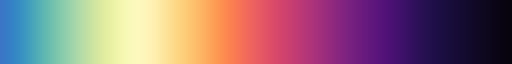

In [14]:
rgb_to_cmap(*svs)[0]

In [172]:
# ESRI Color Ramps JSON format example
# {
#   "type": "multipart",
#   "colorRamps": [
#     {
#       "type": "algorithmic",
#       "fromColor": <color>,
#       "toColor": <color>,
#       "algorithm": <"esriHSVAlgorithm" | "esriCIELabAlgorithm" | "esriLabLChAlgorithm">
#       "start": <double>,
#       "stop": <double>
#     },
#     {
#       "type": "algorithmic",
#       "fromColor": <color>,
#       "toColor": <color>,
#       "algorithm": <"esriHSVAlgorithm" | "esriCIELabAlgorithm" | "esriLabLChAlgorithm">
#       "start": <double>,
#       "stop": <double>
#     }
#   ]
# }

In [7]:
# Generated by Copilot
import matplotlib.colors as mcolors
import numpy as np
from colorspacious import cspace_convert



def create_cmap_from_rgb_list(rgb_list):
    """Create matplotlib colormap from list of RGB tuples"""
    r,g, b = np.vstack(rgb_list).T
    return rgb_to_cmap(r, g, b, len(rgb_list), listed=True)

def create_esri_style_colormap(r, g, b, algorithm="esriHSVAlgorithm", N=256):
    if algorithm == "esriHSVAlgorithm":
        return interpolate_hsv(r, g, b, N)
    elif algorithm == "esriCIELabAlgorithm":
        return interpolate_cielab(r, g, b, N)
    elif algorithm == "esriLabLChAlgorithm":
        return interpolate_lch(r, g, b, N)
    else:
        return interpolate_rgb(r, g, b, N)

def interpolate_hsv(r, g, b, N):
    """Interpolate colors in HSV space (esriHSVAlgorithm)"""
    positions = np.linspace(0, 1, len(r))
    
    # Convert RGB to HSV
    hsv_colors = [mcolors.rgb_to_hsv(color) for color in zip(r, g, b)]
    
    # Interpolate each HSV component separately
    x = np.linspace(0, 1, N)
    h_interp = np.interp(x, positions, [hsv[0] for hsv in hsv_colors])
    s_interp = np.interp(x, positions, [hsv[1] for hsv in hsv_colors])
    v_interp = np.interp(x, positions, [hsv[2] for hsv in hsv_colors])
    
    # Convert back to RGB
    rgb_result = []
    for h, s, v in zip(h_interp, s_interp, v_interp):
        rgb = mcolors.hsv_to_rgb([h, s, v])
        rgb_result.append(rgb)
    
    return create_cmap_from_rgb_list(rgb_result)

def interpolate_cielab(r, g, b, N):
    """Interpolate colors in CIE Lab space (esriCIELabAlgorithm)"""
    positions = np.linspace(0, 1, len(r))
    
    # Convert RGB to CIE Lab using colorspacious
    lab_colors = [cspace_convert(color, "sRGB1", "CIELab") for color in zip(r, g, b)]
    
    # Interpolate each Lab component
    x = np.linspace(0, 1, N)
    l_interp = np.interp(x, positions, [lab[0] for lab in lab_colors])
    a_interp = np.interp(x, positions, [lab[1] for lab in lab_colors])
    b_interp = np.interp(x, positions, [lab[2] for lab in lab_colors])
    
    # Convert back to RGB
    rgb_result = []
    for l, a, b in zip(l_interp, a_interp, b_interp):
        rgb = cspace_convert([l, a, b], "CIELab", "sRGB1")
        # Clamp values to [0, 1]
        rgb = np.clip(rgb, 0, 1)
        rgb_result.append(rgb)
    
    return create_cmap_from_rgb_list(rgb_result)

def interpolate_lch(r, g, b, N):
    """Interpolate colors in CIE LCh space (esriLabLChAlgorithm)"""
    positions = np.linspace(0, 1, len(r))
    
    # Convert RGB to CIE LCh using colorspacious
    lch_colors = [cspace_convert(color, "sRGB1", "CIELCh") for color in zip(r, g, b)]
    
    # Interpolate each LCh component
    x = np.linspace(0, 1, N)
    l_interp = np.interp(x, positions, [lch[0] for lch in lch_colors])
    c_interp = np.interp(x, positions, [lch[1] for lch in lch_colors])
    h_interp = np.interp(x, positions, [lch[2] for lch in lch_colors])
    
    # Convert back to RGB
    rgb_result = []
    for l, c, h in zip(l_interp, c_interp, h_interp):
        rgb = cspace_convert([l, c, h], "CIELCh", "sRGB1")
        # Clamp values to [0, 1]
        rgb = np.clip(rgb, 0, 1)
        rgb_result.append(rgb)
    
    return create_cmap_from_rgb_list(rgb_result)

def interpolate_rgb(r, g, b, N):
    """Standard RGB interpolation (matplotlib default)"""
    positions = np.linspace(0, 1, len(r))
    rgb_colors = zip(r, g, b)
    
    x = np.linspace(0, 1, N)
    r_interp = np.interp(x, positions, r)
    g_interp = np.interp(x, positions, g)
    b_interp = np.interp(x, positions, b)
    
    rgb_result = list(zip(r_interp, g_interp, b_interp))
    return create_cmap_from_rgb_list(rgb_result)


def color_stops_from_rgb(r, g, b):
    """Create color stops from RGB values"""
    positions = np.linspace(0, 1, len(r))
    return list(zip(positions, zip(r, g, b)))

def json_partial(fromColor, toColor, start, stop):
    """Generate a JSON partial for ESRI color ramps"""
    return {
        "type": "algorithmic",
        "fromColor": fromColor,
        "toColor": toColor,
        "algorithm": "esriCIELabAlgorithm",
        "start": start,
        "stop": stop
    }

def rgb_to_lab_colorramp(r,g,b,N = 11):
    _, rgb_downsamples = rgb_to_cmap(r,g,b, N)
    # cmap_lab, lab_rgb = create_esri_style_colormap(*rgb_downsamples, "esriCIELabAlgorithm") 
    
    # create the needed json parts
    color_stops = as_float(color_stops_from_rgb(*rgb_downsamples))
    parts = []
    for i in range(len(color_stops)-1):
        parts.append(json_partial(
            fromColor = list(map(int, np.array(color_stops[i][1])*255)) + [255],
            toColor = list(map(int, np.array(color_stops[i+1][1])*255)) + [255],
            start = (color_stops[i][0] ),
            stop = (color_stops[i+1][0] )
        ))
    return {
        "type": "multipart",
        "colorRamps": parts
    }

def rgb_plots(rgb, label='', c=None):
    """Plot RGB channels"""
    r, g, b = rgb
    t = np.linspace(0, 1, len(r))
    plt.plot(t, r, label='R' + label, color=c or 'r')
    plt.plot(t, g, label='G' + label, color=c or 'g')
    plt.plot(t, b, label='B' + label, color=c or 'b')


In [8]:
import json
def preview_cmap_changes(rgb, N = 22): 
    r, g, b = rgb
    cmap, _ = rgb_to_cmap(*rgb, listed=True)
    cmapN, rgbN = rgb_to_cmap(r, g, b, N, listed=True)
    cmap_lab, rgb_lab = create_esri_style_colormap(*rgbN, "esriCIELabAlgorithm") 
    # svsN_cmap_hsv, svsN_hsv = create_esri_style_colormap(*svsN, "esriHSVAlgorithm") # these wrap around the hue
    # svsN_cmap_lch, svsN_lch = create_esri_style_colormap(*svsN, "esriLabLChAlgorithm") # these wrap around the hue
    # svsN_cmap_rgb, svsN_rgb = create_esri_style_colormap(*svsN, "rgb")

    print('original:')
    display(Image(cmap._repr_png_()))
    print(f'downsampled (N={N}):')
    display(Image(cmapN._repr_png_()))
    print('CIE interpolated:')
    display(Image(cmap_lab._repr_png_()))


    with plt.style.context('dark_background'):
        rgb_plots(rgb, ' (original)', c='0.5')
        rgb_plots(rgb_lab, ' (CIE)')
        plt.legend()
        plt.show()

def append_as_esri_colorramp(ts_file, name, rgb, N=22):
    colorRamp = rgb_to_lab_colorramp(*rgb, N)
    
    # Append the JSON to the file
    with open(ts_file, 'a') as f:
        valid_json = json.dumps(colorRamp, indent=2)
        f.write(f'\n\nexport const {name} = {valid_json};\n')

original:


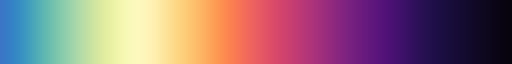

downsampled (N=3):


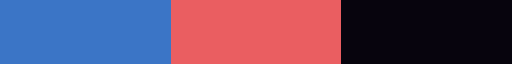

CIE interpolated:


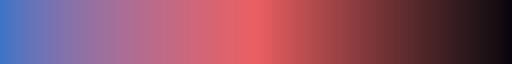

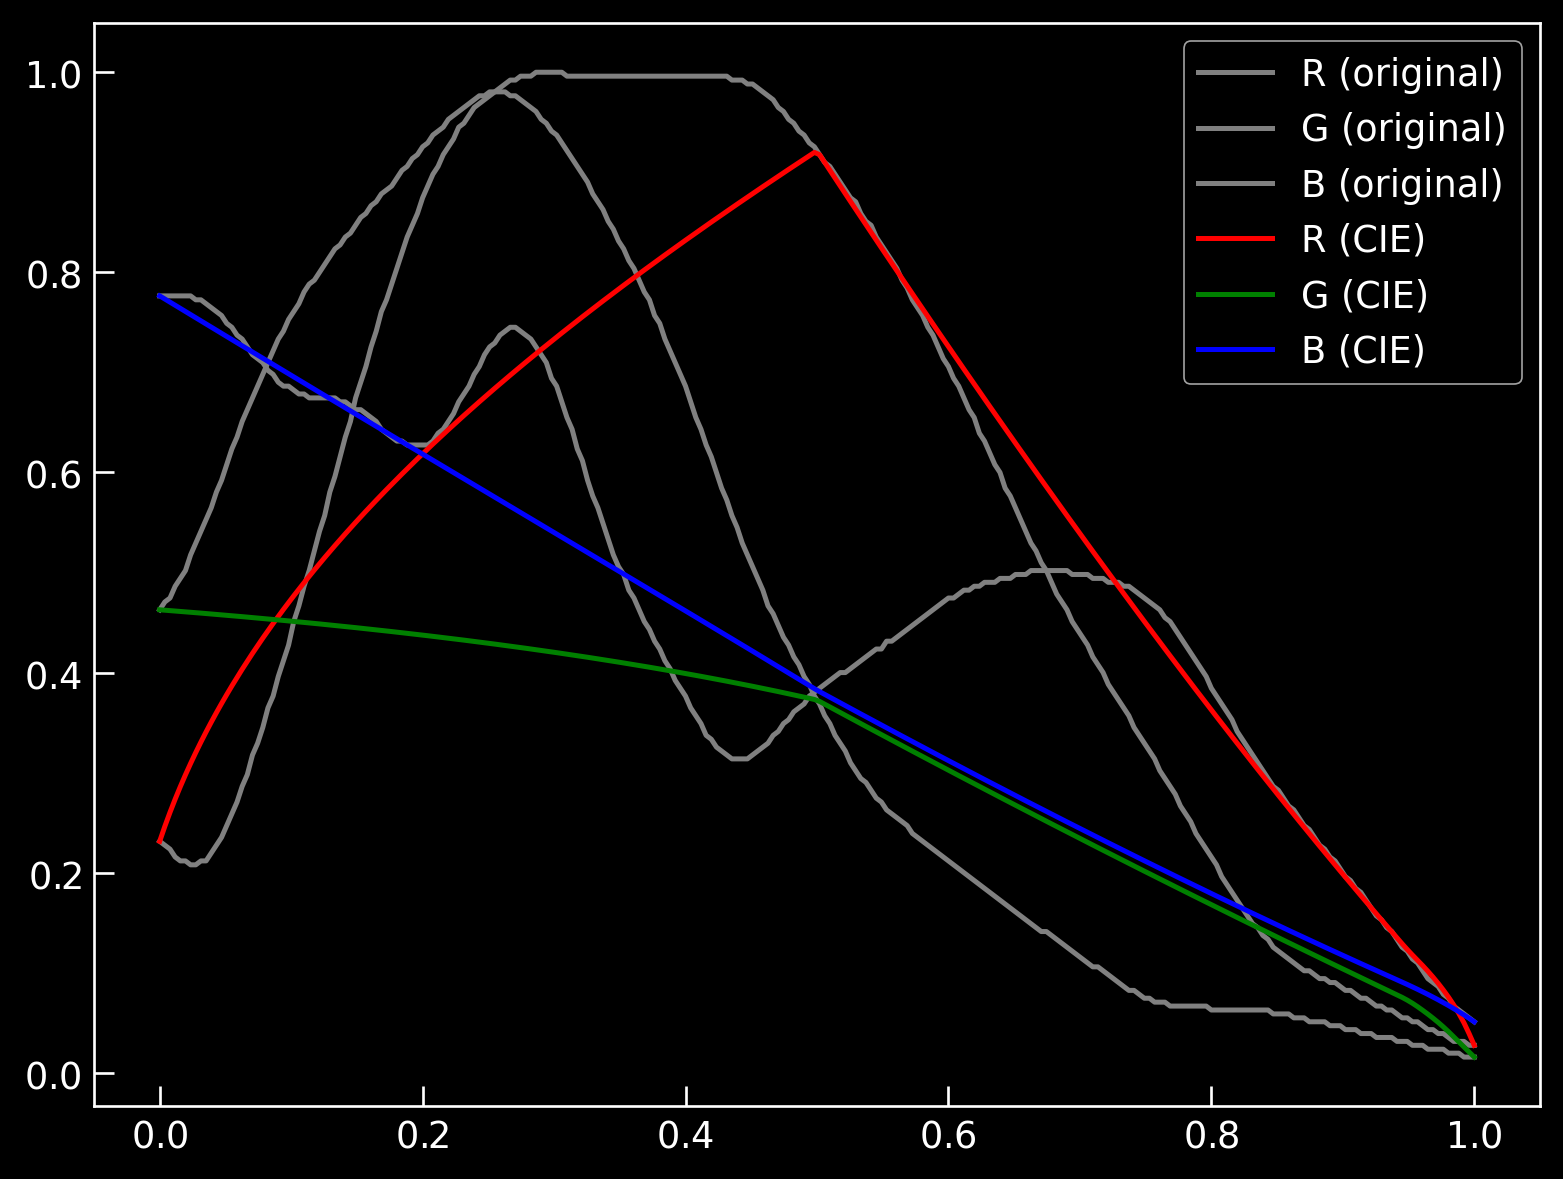

In [17]:
preview_cmap_changes(svs, 3)

original:


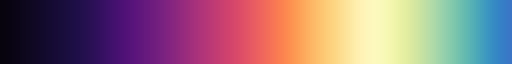

downsampled (N=22):


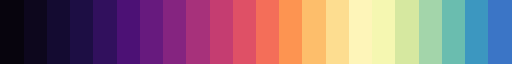

CIE interpolated:


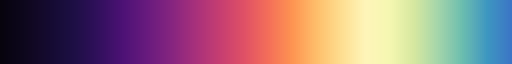

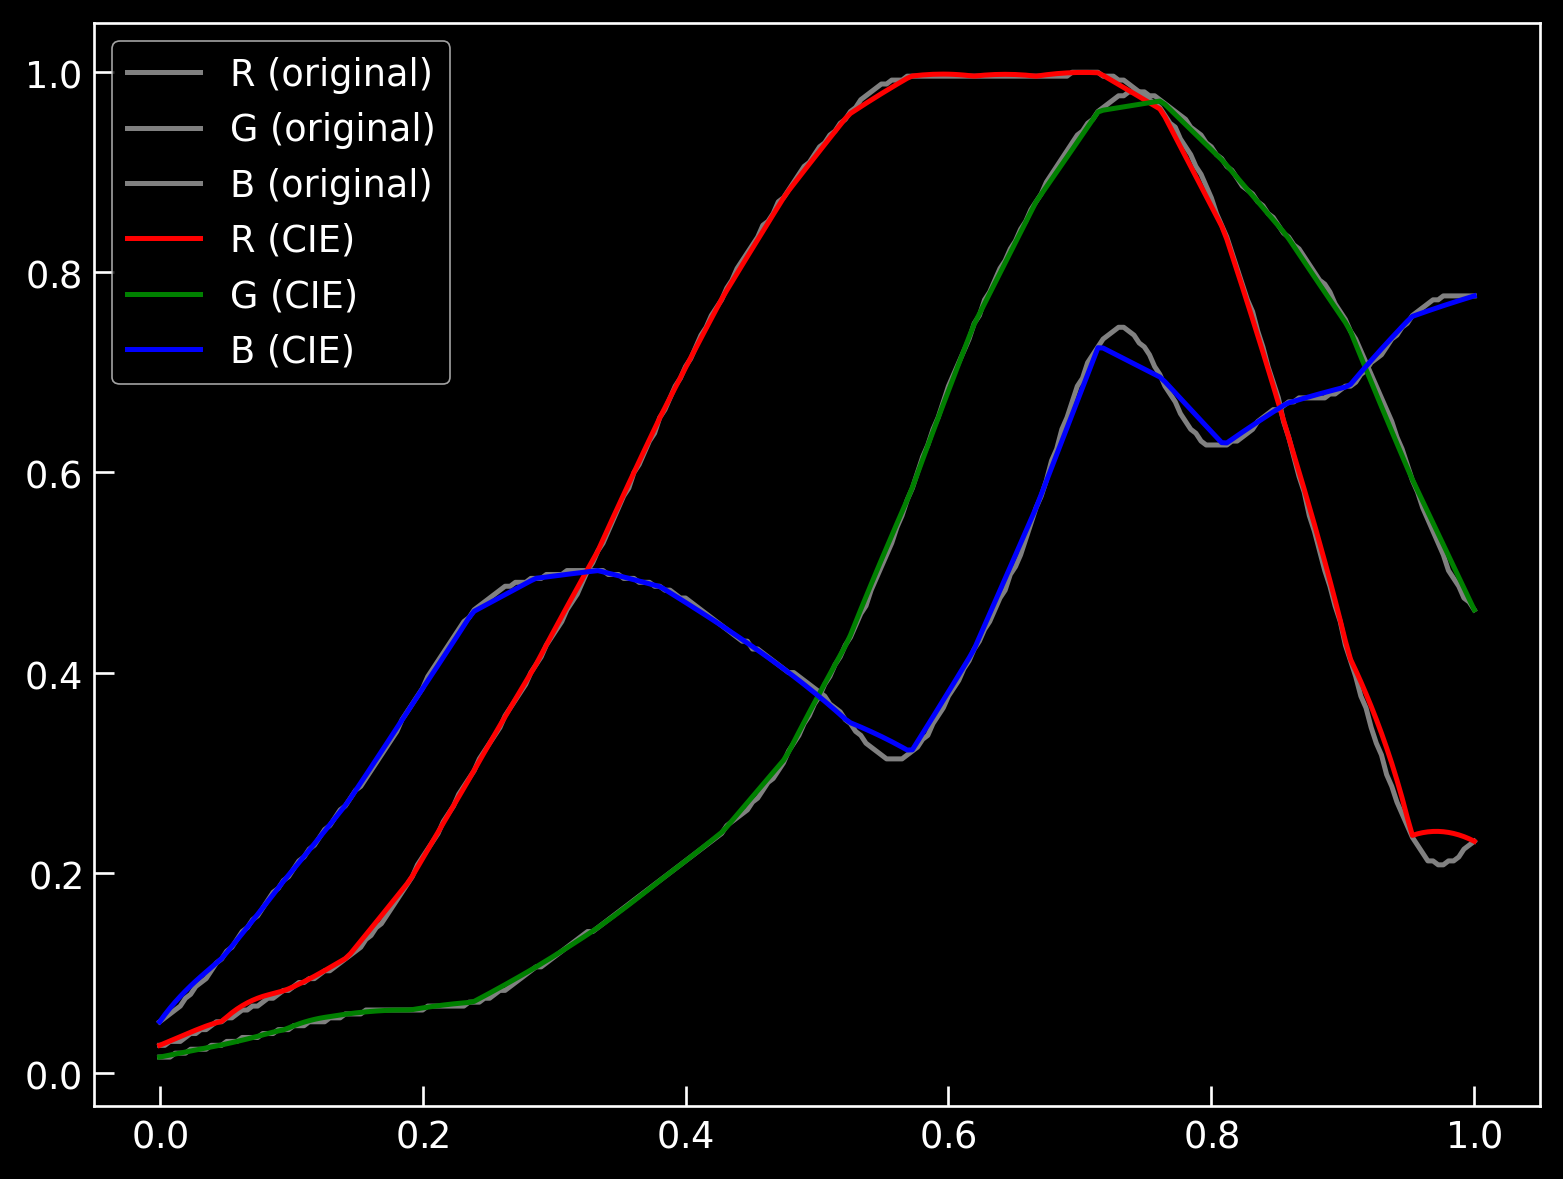

In [270]:
%run -i "./src/svs.py"
ts_file = output_dir / "svs_nitrogen_dioxide.ts"
svs = [v[::-1] for v in svs]
preview_cmap_changes(svs, 22)
generate_typescript_file("svs_nitrogen_dioxide", *svs)
append_as_esri_colorramp(ts_file, "svsColorRamp", svs, 22)


original:


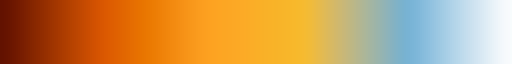

downsampled (N=22):


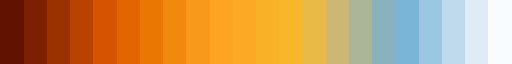

CIE interpolated:


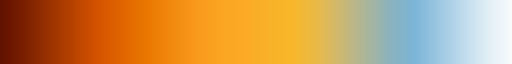

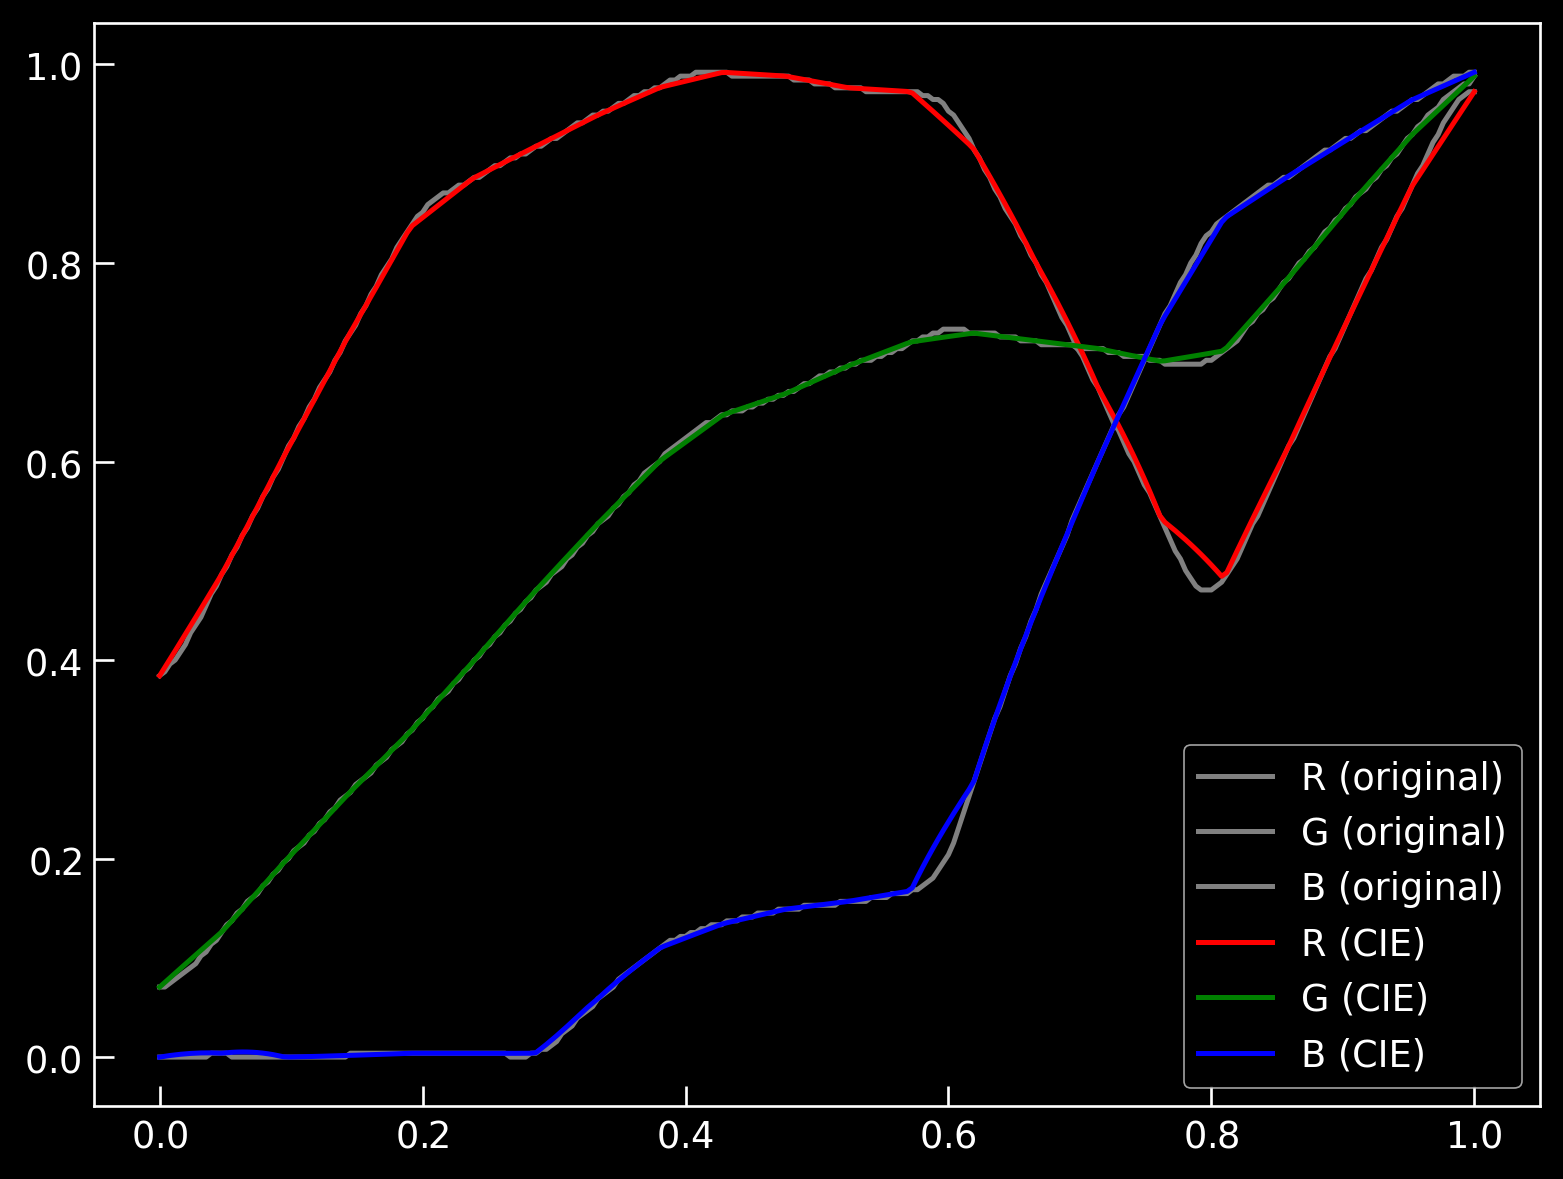

In [18]:
act_file = output_dir.parent / "act" / "EO_sargassum_tamo.act"
sargassum_rgb = [v[::-1] for v in act_to_rgb(act_file)]
preview_cmap_changes(sargassum_rgb, 22)

In [264]:
typescript_file = output_dir / "sargassum.ts"
generate_typescript_file("sargassum", *sargassum_rgb)
generate_index_file(cmap_names + ["sargassum"])
append_as_esri_colorramp(typescript_file, "sargassumColorRamp", sargassum_rgb, 22)

In [268]:
generate_index_file(cmap_names + ["sargassum", "svs_nitrogen_dioxide"])

PosixPath('src/colormaps/index.ts')

original:


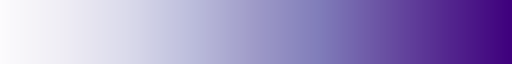

downsampled (N=10):


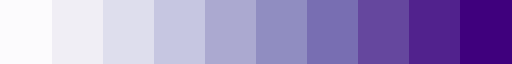

CIE interpolated:


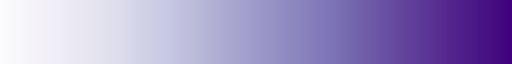

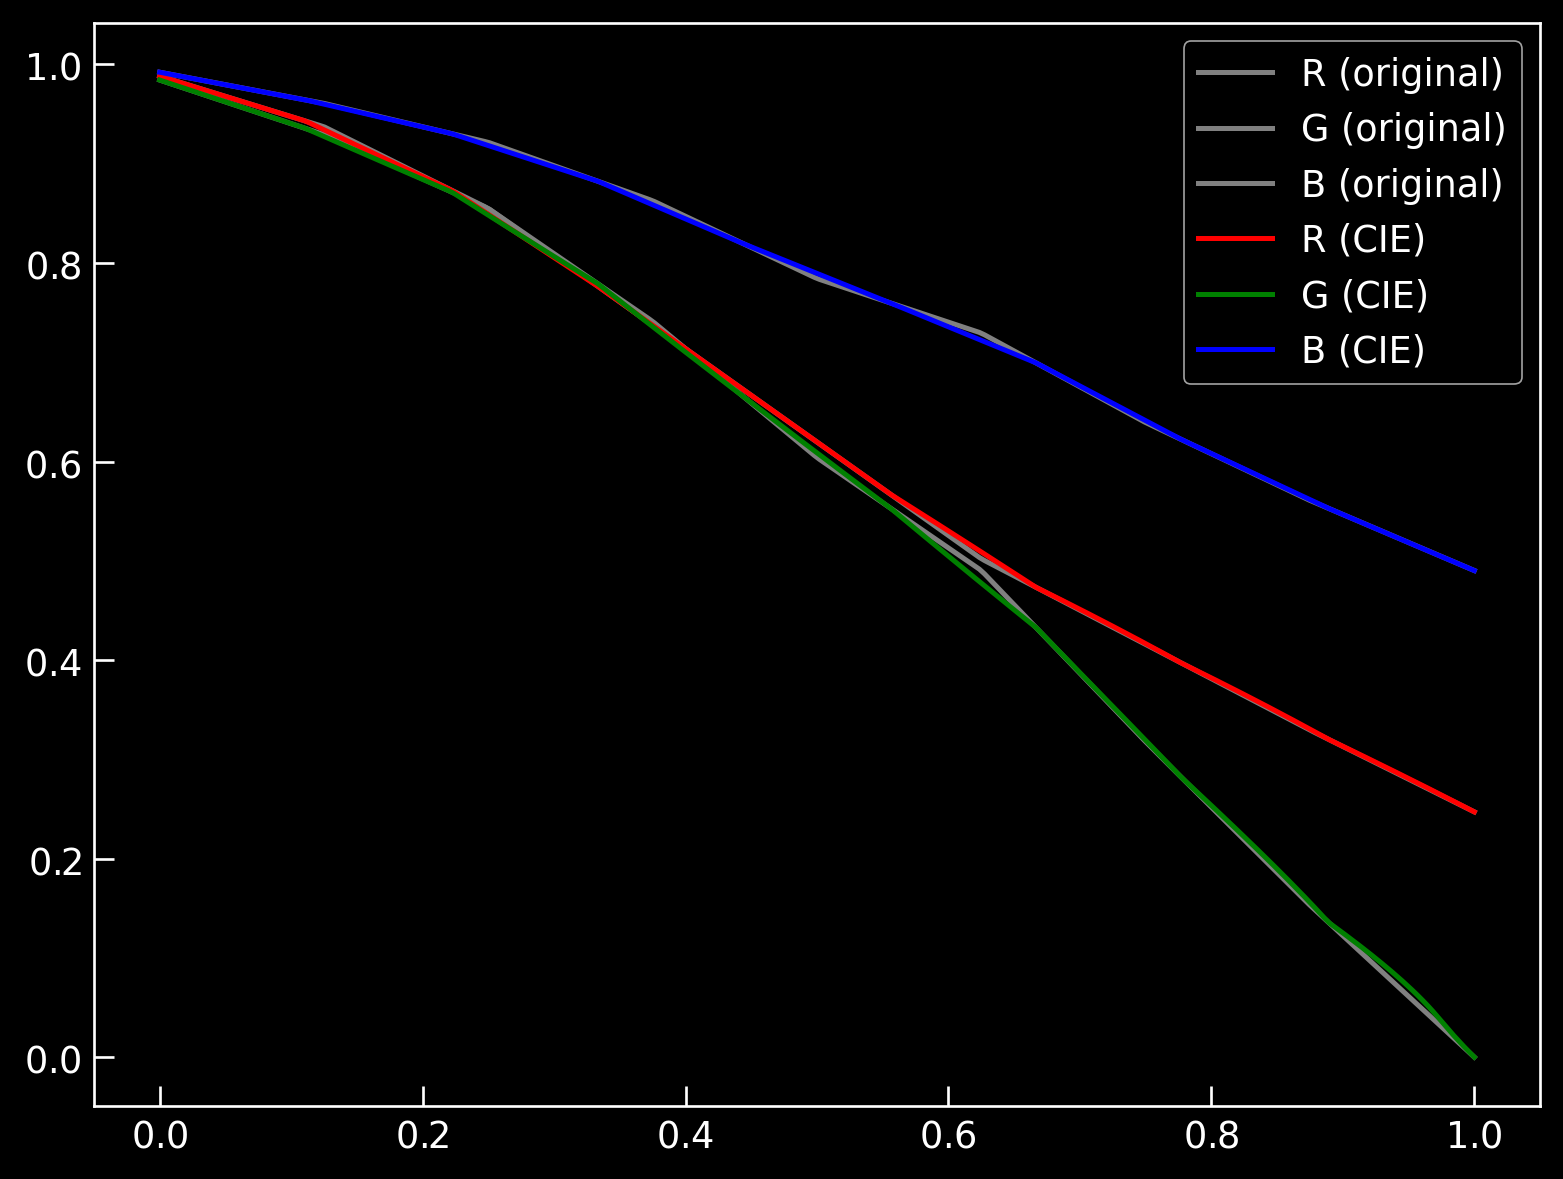

In [21]:
turbo = read_ts_colormap_file(all_colormaps / "Purples.ts")
turbo_cmap, turbo_rgb = rgb_to_cmap(*turbo)
preview_cmap_changes(turbo, 10)